In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import joblib


In [3]:
data = joblib.load('data_with_features.joblib')
data

,ECNumber,Organism,Smiles,Substrate,Sequence,Raw Kd,Unit,Log Kd,metabolite_features,protein_features
0,4.2.3.4,Actinidia chinensis,C(C(C(C(COP(=O)(O)O)O)O)O)C(=O)C(=O)O,3-deoxy-D-arabino-heptulosonic acid 7-phosphate,MAAFSLSAKQILSPSTHRPSLSKTTTADSSLRFRNPHSLSLRCSSL...,20.1000,s^(-1),1.303196,"[0.09045384, -0.6035856, -0.5294743, 0.0703877...","[-0.12646541, -0.15512069, 0.0834027, 0.213126..."
1,4.2.3.4,Aspergillus nidulans,C(C(C(C(COP(=O)([O-])[O-])O)O)O)C(=O)C(=O)[O-],3-deoxy-D-arabino-heptulosonate 7-phosphate,MSNPTKISILGRESIIADFGLWRNYVAKDLISDCSSTTYVLVTDTN...,6.8000,s^(-1),0.832509,"[0.4610253, 0.039623156, -0.4662559, 0.4188257...","[-0.10084063, -0.099633686, -0.011382125, 0.10..."
2,4.2.3.4,Neurospora crassa,C(C(C(C(COP(=O)(O)O)O)O)O)C(=O)C(=O)O,3-deoxy-D-arabino-heptulosonic acid 7-phosphate,MAEPISNPTRINILGKDNIIIDHGIWLNFVAQDLLQNIKSSTYILI...,19.0000,s^(-1),1.278754,"[0.09045384, -0.6035856, -0.5294743, 0.0703877...","[-0.12705962, -0.09898393, 0.0041820942, 0.096..."
3,2.1.1.255,Streptomyces coelicolor,C[S+](CCC(C(=O)[O-])N)CC1C(C(C(O1)N2C=NC3=C(N=...,S-Adenosyl-L-methionine,MTTETTTATATAKIPAPATPYQEDIARYWNNEARPVNLRLGDVDGL...,0.0075,s^(-1),-2.124939,"[0.52348095, -0.18665986, -0.39555183, 0.11716...","[0.0015065962, -0.087554656, -0.014490904, -0...."
4,2.1.1.255,Streptomyces coelicolor,CC(=CCCC(=C(C)COP(=O)(O)OP(=O)(O)O)C)C,(E)-2-Methylgeranyl diphosphate,MTTETTTATATAKIPAPATPYQEDIARYWNNEARPVNLRLGDVDGL...,0.0390,s^(-1),-1.408935,"[0.17630623, -0.4595529, -0.6368343, -0.136045...","[0.0015065962, -0.087554656, -0.014490904, -0...."
...,...,...,...,...,...,...,...,...,...,...
17005,1.1.1.82,Zea mays,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,NADPH,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,955.0000,s^(-1),2.980003,"[0.36284313, -0.21340896, -0.8913718, -0.23485...","[0.039386757, -0.04558141, 0.101506, 0.1012840..."
17006,1.1.1.82,Zea mays,C(C(C(=O)O)O)C(=O)O,L-Malate,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,2.9000,s^(-1),0.462398,"[0.045168612, -0.31311044, -0.21087039, -0.292...","[0.039386757, -0.04558141, 0.101506, 0.1012840..."
17007,1.1.1.82,Zea mays,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)(O)OP(=O)(O...,NADP+,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,2.9000,s^(-1),0.462398,"[0.18913552, -0.06542938, -0.8761325, 0.133454...","[0.039386757, -0.04558141, 0.101506, 0.1012840..."
17008,1.1.1.82,Spinacia oleracea,C(C(C(=O)O)O)C(=O)O,L-Malate,MAVAELSPCYQTQIVKPPHLSWLSNNHKLNLLGLPKASRITEICCS...,6.7000,s^(-1),0.826075,"[0.045168612, -0.31311044, -0.21087039, -0.292...","[0.029217303, -0.08372673, 0.0883128, 0.147737..."


In [4]:
# adding 1e-9 to prevent error when doing logarithm
data['label'] = -np.log10(data['Raw Kd'] + 1e-9)

In [11]:
# Define dataset
class MPI_Dataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        return {
            'metabolite_features': torch.tensor(np.asarray(row['metabolite_features'], dtype=np.float32)),
            'protein_features': torch.tensor(np.asarray(row['protein_features'], dtype=np.float32)),
            'label': torch.tensor(float(row['label']), dtype=torch.float32),
        }

In [12]:
data.columns

Index(['ECNumber', 'Organism', 'Smiles', 'Substrate', 'Sequence', 'Raw Kd',
       'Unit', 'Log Kd', 'metabolite_features', 'protein_features', 'label'],
      dtype='object')

In [13]:
# Load data
# Assuming `combined_df` is a pandas DataFrame containing all necessary columns
train_df, temp_df = train_test_split(data, test_size=0.3, shuffle=True, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True, random_state=42)

train_X = np.array([
    np.concatenate([m, p])
    for m, p in zip(train_df['metabolite_features'], train_df['protein_features'])
])
train_y = train_df['label']
val_X = np.array([
    np.concatenate([m, p])
    for m, p in zip(val_df['metabolite_features'], val_df['protein_features'])
])
val_y = val_df['label']
test_X = np.array([
    np.concatenate([m, p])
    for m, p in zip(test_df['metabolite_features'], test_df['protein_features'])
])
test_y = test_df['label']


'''
from sklearn.model_selection import PredefinedSplit
split_index = [-1]*len(train_X) + [0]*len(val_X)
X = np.concatenate((train_X,val_X),axis=0)
y = np.concatenate((train_y,val_y),axis=0)
pds = PredefinedSplit(test_fold=split_index)
'''



'''
train_dataset = MPI_Dataset(train_df)
val_dataset = MPI_Dataset(val_df)
test_dataset = MPI_Dataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)
'''

'\ntrain_dataset = MPI_Dataset(train_df)\nval_dataset = MPI_Dataset(val_df)\ntest_dataset = MPI_Dataset(test_df)\n\ntrain_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)\nval_loader = DataLoader(val_dataset, batch_size=32)\ntest_loader = DataLoader(test_dataset, batch_size=32)\n'

In [14]:
#model initialization
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

In [5]:
'''
#Grid search
from sklearn.model_selection import GridSearchCV
param_grid = dict(
    n_estimators = [50,100,150,200],
    max_depth = [10,20,30,None]
)
regressor = GridSearchCV(estimator = rf, param_grid = param_grid, cv = pds, verbose = 3, n_jobs = -1)

'''

#Train the model
# rf.fit(train_X,train_y)

rf=joblib.load('./../../trained_model/random_split/RF model.joblib')

In [6]:
predictions=rf.predict(np.array([
    np.concatenate([m, p])
    for m, p in zip(data['metabolite_features'], data['protein_features'])
]))

import os
if os.path.exists('data_with_pred.joblib'):
    data_with_pred = joblib.load('data_with_pred.joblib')
else:
    data_with_pred = data.copy()

data_with_pred["RF_pred"] = predictions
joblib.dump(data_with_pred, 'data_with_pred.joblib')
data_with_pred

,ECNumber,Organism,Smiles,Substrate,Sequence,Raw Kd,Unit,Log Kd,metabolite_features,protein_features,label,CAT_pred,CNN_pred,GBM_pred,LR_pred,MLP_pred,RF_pred
0,4.2.3.4,Actinidia chinensis,C(C(C(C(COP(=O)(O)O)O)O)O)C(=O)C(=O)O,3-deoxy-D-arabino-heptulosonic acid 7-phosphate,MAAFSLSAKQILSPSTHRPSLSKTTTADSSLRFRNPHSLSLRCSSL...,20.1000,s^(-1),1.303196,"[0.09045384, -0.6035856, -0.5294743, 0.0703877...","[-0.12646541, -0.15512069, 0.0834027, 0.213126...",-1.303196,-0.664597,-1.227315,-0.456274,0.046098,-0.033697,-0.663813
1,4.2.3.4,Aspergillus nidulans,C(C(C(C(COP(=O)([O-])[O-])O)O)O)C(=O)C(=O)[O-],3-deoxy-D-arabino-heptulosonate 7-phosphate,MSNPTKISILGRESIIADFGLWRNYVAKDLISDCSSTTYVLVTDTN...,6.8000,s^(-1),0.832509,"[0.4610253, 0.039623156, -0.4662559, 0.4188257...","[-0.10084063, -0.099633686, -0.011382125, 0.10...",-0.832509,-0.298970,-0.735445,-0.562968,-0.532851,-0.595165,-0.703961
2,4.2.3.4,Neurospora crassa,C(C(C(C(COP(=O)(O)O)O)O)O)C(=O)C(=O)O,3-deoxy-D-arabino-heptulosonic acid 7-phosphate,MAEPISNPTRINILGKDNIIIDHGIWLNFVAQDLLQNIKSSTYILI...,19.0000,s^(-1),1.278754,"[0.09045384, -0.6035856, -0.5294743, 0.0703877...","[-0.12705962, -0.09898393, 0.0041820942, 0.096...",-1.278754,-0.836997,-1.242703,-0.699874,-0.381774,-0.972310,-1.196758
3,2.1.1.255,Streptomyces coelicolor,C[S+](CCC(C(=O)[O-])N)CC1C(C(C(O1)N2C=NC3=C(N=...,S-Adenosyl-L-methionine,MTTETTTATATAKIPAPATPYQEDIARYWNNEARPVNLRLGDVDGL...,0.0075,s^(-1),-2.124939,"[0.52348095, -0.18665986, -0.39555183, 0.11716...","[0.0015065962, -0.087554656, -0.014490904, -0....",2.124939,1.427049,0.659172,0.767883,0.932206,1.383574,0.971980
4,2.1.1.255,Streptomyces coelicolor,CC(=CCCC(=C(C)COP(=O)(O)OP(=O)(O)O)C)C,(E)-2-Methylgeranyl diphosphate,MTTETTTATATAKIPAPATPYQEDIARYWNNEARPVNLRLGDVDGL...,0.0390,s^(-1),-1.408935,"[0.17630623, -0.4595529, -0.6368343, -0.136045...","[0.0015065962, -0.087554656, -0.014490904, -0....",1.408935,0.783579,1.170299,0.016693,0.681809,1.515772,1.115315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17005,1.1.1.82,Zea mays,C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(...,NADPH,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,955.0000,s^(-1),2.980003,"[0.36284313, -0.21340896, -0.8913718, -0.23485...","[0.039386757, -0.04558141, 0.101506, 0.1012840...",-2.980003,-1.987372,-2.852437,-1.338873,-1.303237,-2.799196,-2.386986
17006,1.1.1.82,Zea mays,C(C(C(=O)O)O)C(=O)O,L-Malate,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,2.9000,s^(-1),0.462398,"[0.045168612, -0.31311044, -0.21087039, -0.292...","[0.039386757, -0.04558141, 0.101506, 0.1012840...",-0.462398,-1.656514,-1.883750,-1.248562,-1.116988,-2.273174,-1.641825
17007,1.1.1.82,Zea mays,C1=CC(=C[N+](=C1)C2C(C(C(O2)COP(=O)(O)OP(=O)(O...,NADP+,MGLSTVYSPAGPRLVPAPLGRCRSAQPRRPRRAPLATVRCSVDATK...,2.9000,s^(-1),0.462398,"[0.18913552, -0.06542938, -0.8761325, 0.133454...","[0.039386757, -0.04558141, 0.101506, 0.1012840...",-0.462398,-1.541640,-0.925752,-1.236483,-1.220809,-0.321132,-0.831630
17008,1.1.1.82,Spinacia oleracea,C(C(C(=O)O)O)C(=O)O,L-Malate,MAVAELSPCYQTQIVKPPHLSWLSNNHKLNLLGLPKASRITEICCS...,6.7000,s^(-1),0.826075,"[0.045168612, -0.31311044, -0.21087039, -0.292...","[0.029217303, -0.08372673, 0.0883128, 0.147737...",-0.826075,-0.926702,-1.843686,-1.031461,-0.986014,-0.721271,-1.044259


In [16]:
# Train
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, explained_variance_score
from scipy.stats import pearsonr

y_train_pred = rf.predict(train_X)

train_mse = mean_squared_error(train_y, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(train_y, y_train_pred)
train_r2 = r2_score(train_y, y_train_pred)
train_pearson_corr, _ = pearsonr(train_y, y_train_pred)
train_median_ae = median_absolute_error(train_y, y_train_pred)
train_explained_var = explained_variance_score(train_y, y_train_pred)


In [17]:
# Validation
y_val_pred = rf.predict(val_X)

val_mse = mean_squared_error(val_y, y_val_pred)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(val_y, y_val_pred)
val_r2 = r2_score(val_y, y_val_pred)
val_pearson_corr, _ = pearsonr(val_y, y_val_pred)
val_median_ae = median_absolute_error(val_y, y_val_pred)
val_explained_var = explained_variance_score(val_y, y_val_pred)

In [18]:
'''
#Choose the best model and test its performance
best_model = regressor.best_estimator_
best_params = regressor.best_params_
print('Best Hyperparameters:',best_params)
'''

# Test
y_test_pred = rf.predict(test_X)

test_mse = mean_squared_error(test_y, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_y, y_test_pred)
test_r2 = r2_score(test_y, y_test_pred)
test_pearson_corr, _ = pearsonr(test_y, y_test_pred)
test_median_ae = median_absolute_error(test_y, y_test_pred)
test_explained_var = explained_variance_score(test_y, y_test_pred)


print(f"Test MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, R-square: {test_r2:.4f}")

Test MSE: 1.0643, MAE: 0.7208, R-square: 0.5270


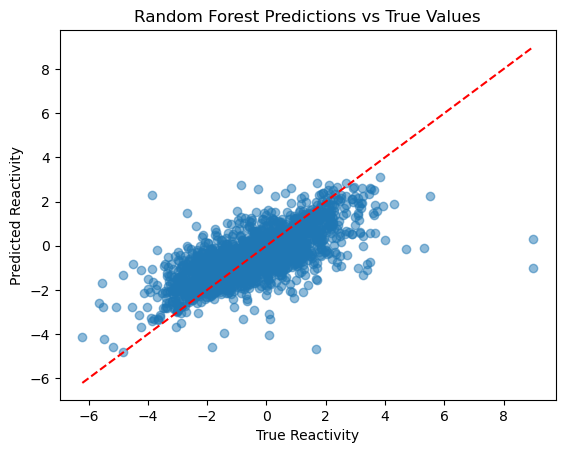

In [19]:
# Plot the performance
import matplotlib.pyplot as plt

plt.scatter(test_y, y_test_pred, alpha=0.5)
plt.xlabel("True Reactivity")
plt.ylabel("Predicted Reactivity")
plt.title("Random Forest Predictions vs True Values")
plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'r--')
plt.show()


In [20]:
# append the performance to the csv file
df = {
    'Model':['Random Forest','Random Forest','Random Forest'],
    'Dataset':['Train','Validation','Test'],
    'MSE':[train_mse,val_mse,test_mse],
    'RMSE':[train_rmse,val_rmse,test_rmse],
    'MAE':[train_mae,val_mae,test_mae],
    'R2':[train_r2,val_r2,test_r2],
    'Pearson':[train_pearson_corr,val_pearson_corr,test_pearson_corr],
    'Median_AE':[train_median_ae,val_median_ae,test_median_ae],
    'Explained_VAR':[train_explained_var,val_explained_var,test_explained_var],
    'Dataspliting Mode':['random','random','random']
}
df = pd.DataFrame(df)

df.to_csv('/Users/pinchichen/2025S lab/AI drug project/code/model performance metrics.csv', mode='a', header=False)

In [21]:
# save the model
from joblib import dump, load

dump(rf, 'trained_model/RF model.joblib')

# load the model
#rf_loaded = load('RF model.joblib')

['trained_model/RF model.joblib']